In [65]:
import torch
import os
import matplotlib.pyplot as plt

In [29]:
def load_params(filepath, map_to_cpu=False):
    if map_to_cpu:
        return torch.load(filepath, map_location=torch.device('cpu'))
    return torch.load(filepath)

In [30]:
def load_all_params(dict, rank, num_epochs=100, map_to_cpu=False):
    params = {}
    for epoch in range(num_epochs):
        path = os.path.join(dict, f"r{rank}-epoch_{epoch}-parameters.pt")
        params[epoch] = load_params(path, map_to_cpu)
    return params

In [31]:
def compare_params(params1, params2):
    param_diff = {}
    for (name1, param1), (name2, param2) in zip(params1.items(), params2.items()):
        if name1 == name2 and param1.dtype.is_floating_point:
            param_diff[name1] = torch.norm(param1 - param2).item()
        # else:
        #     print(f"Skipping {name1} because they are not the same type or name.")
    return param_diff


In [32]:
def compare_all_params_between_epochs(params):
    param_diffs = {}
    sorted_epochs = sorted(params.keys())
    for i in range(len(sorted_epochs) - 1):
        epoch1 = sorted_epochs[i]
        epoch2 = sorted_epochs[i + 1]
        param_diffs[(epoch1, epoch2)] = compare_params(params[epoch1], params[epoch2])
    return param_diffs

In [46]:
def compare_all_params_between_ranks(params1, params2, num_epochs):
    epoch_diffs = {}
    for epoch in range(num_epochs):
        param_diffs = {}
        for param_name in params1[epoch]:
            if params1[epoch][param_name].dtype.is_floating_point:
                param_diffs[param_name] = torch.norm(params1[epoch][param_name] - params2[epoch][param_name]).item()
        epoch_diffs[epoch] = param_diffs
    return epoch_diffs

In [34]:
def print_model_layers(model_params):
    for name, param in model_params.items():
        print(name, param.size())

In [35]:
def plot_param_changes(param_diffs, param_name):
    epochs = []
    changes = []
    for (epoch1, epoch2), diffs in param_diffs.items():
        if param_name in diffs:
            epochs.append(epoch2)
            changes.append(diffs[param_name])
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, changes)
    plt.xlabel("Epoch")
    plt.ylabel("L2 norm of change")
    plt.title(f"Change in {param_name} over epochs")
    plt.grid(True)
    plt.show()

In [71]:
def plot_all_param_changes(param_diffs):
    unique_params = set()
    for diffs in param_diffs.values():
        unique_params.update(diffs.keys())
    
    plt.figure(figsize=(15, 8))
    for param_name in unique_params:
        epochs = []
        changes = []
        for (epoch1, epoch2), diffs in param_diffs.items():
            if param_name in diffs:
                epochs.append(epoch2)
                changes.append(diffs[param_name])
        plt.plot(epochs, changes, label=param_name)

    plt.xlabel("Epoch")
    plt.ylabel("L2 norm of change")
    plt.title(f"Change in {param_name} over epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
def plot_param_changes_over_epochs(param_diffs, param_name):
    epochs = list(param_diffs.keys())
    changes = [param_diffs[epoch][param_name] for epoch in epochs if param_name in param_diffs[epoch]]     
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, changes)
    plt.xlabel("Epoch")
    plt.ylabel("L2 norm of change")
    plt.title(f"Change in {param_name} over epochs")
    plt.grid(True)
    plt.show()

In [62]:
# plot all changes in a parameter over epochs in a single plot
def plot_all_param_changes_between_nodes(param_diffs):
    epochs = list(param_diffs.keys())
    plt.figure(figsize=(14, 10))
    for param_name in param_diffs[epochs[0]]:
        changes = [param_diffs[epoch][param_name] for epoch in epochs if param_name in param_diffs[epoch]]
        plt.plot(epochs, changes, label=param_name)

In [37]:
dict = 'Output/swift-iid-8W-pattern1-ring-2sgd-200epochs/'
params = load_params(os.path.join(dict, 'r0-epoch_0-parameters.pt'), map_to_cpu=True)

In [38]:
print_model_layers(params)

conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
bn1.weight torch.Size([16])
bn1.bias torch.Size([16])
bn1.running_mean torch.Size([16])
bn1.running_var torch.Size([16])
bn1.num_batches_tracked torch.Size([])
layer1.0.conv1.weight torch.Size([16, 16, 3, 3])
layer1.0.conv1.bias torch.Size([16])
layer1.0.bn1.weight torch.Size([16])
layer1.0.bn1.bias torch.Size([16])
layer1.0.bn1.running_mean torch.Size([16])
layer1.0.bn1.running_var torch.Size([16])
layer1.0.bn1.num_batches_tracked torch.Size([])
layer1.0.conv2.weight torch.Size([16, 16, 3, 3])
layer1.0.conv2.bias torch.Size([16])
layer1.0.bn2.weight torch.Size([16])
layer1.0.bn2.bias torch.Size([16])
layer1.0.bn2.running_mean torch.Size([16])
layer1.0.bn2.running_var torch.Size([16])
layer1.0.bn2.num_batches_tracked torch.Size([])
layer1.1.conv1.weight torch.Size([16, 16, 3, 3])
layer1.1.conv1.bias torch.Size([16])
layer1.1.bn1.weight torch.Size([16])
layer1.1.bn1.bias torch.Size([16])
layer1.1.bn1.running_mean torch.S

In [39]:
all_params = load_all_params(dict, 0, num_epochs=200, map_to_cpu=True)
param_diffs = compare_all_params_between_epochs(all_params)

In [40]:
def print_model_layers_and_types(model_params):
    for name, param in model_params.items():
        print(name, param.size(), param.dtype)

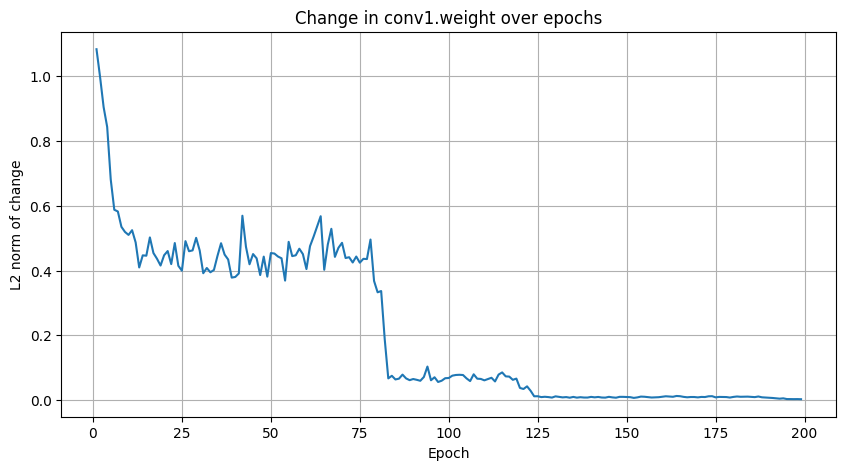

In [41]:
plot_param_changes(param_diffs, 'conv1.weight')

In [48]:
node0_params = load_all_params(dict, 0, num_epochs=200, map_to_cpu=True)    
node1_params = load_all_params(dict, 1, num_epochs=200, map_to_cpu=True)
node2_params = load_all_params(dict, 2, num_epochs=200, map_to_cpu=True)
node3_params = load_all_params(dict, 3, num_epochs=200, map_to_cpu=True)
node4_params = load_all_params(dict, 4, num_epochs=200, map_to_cpu=True)
node5_params = load_all_params(dict, 5, num_epochs=200, map_to_cpu=True)
node6_params = load_all_params(dict, 6, num_epochs=200, map_to_cpu=True)
node7_params = load_all_params(dict, 7, num_epochs=200, map_to_cpu=True)

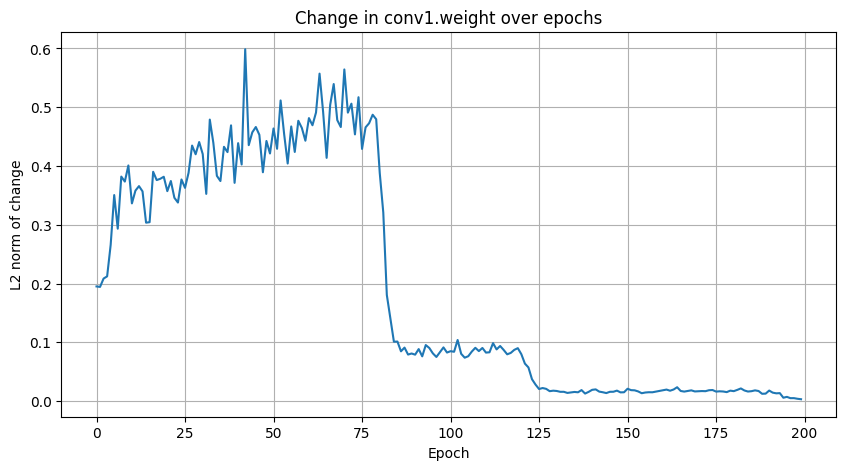

In [47]:
param_diffs_between_0_and_1 = compare_all_params_between_ranks(node0_params, node1_params, 200)
plot_param_changes_over_epochs(param_diffs_between_0_and_1, 'bn1.weight')

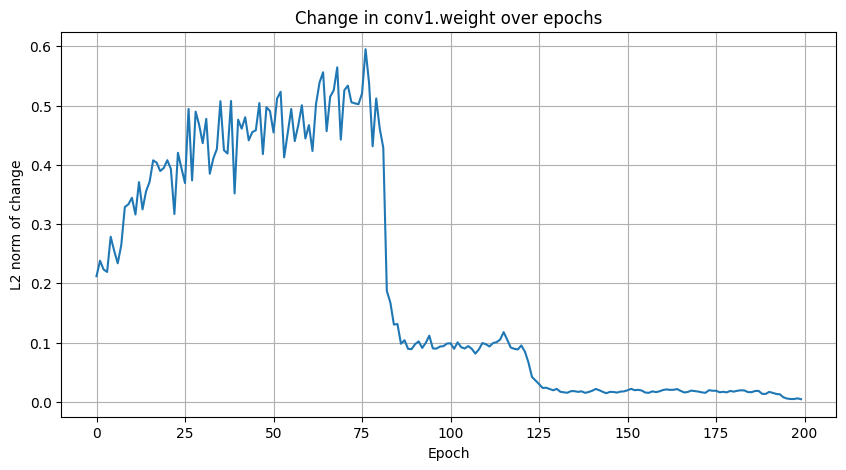

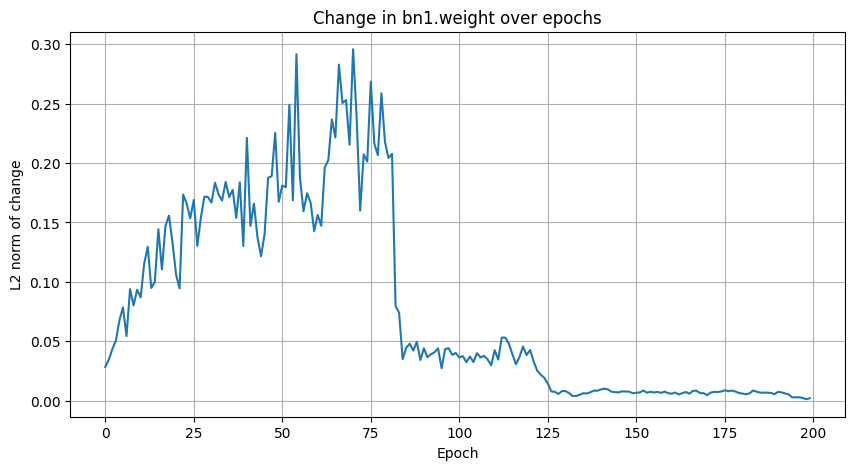

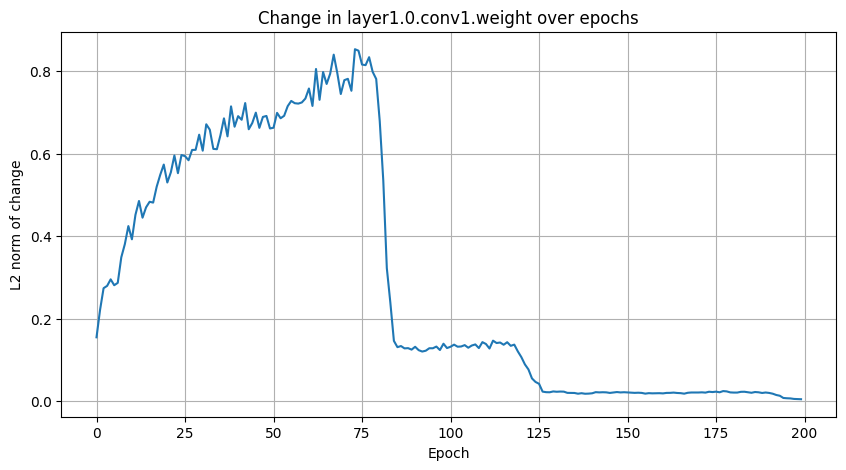

In [55]:
param_diffs_between_0_and_2 = compare_all_params_between_ranks(node0_params, node2_params, 200)
plot_param_changes_over_epochs(param_diffs_between_0_and_2, 'conv1.weight')
plot_param_changes_over_epochs(param_diffs_between_0_and_2, 'bn1.weight')
plot_param_changes_over_epochs(param_diffs_between_0_and_2, 'layer1.0.conv1.weight')

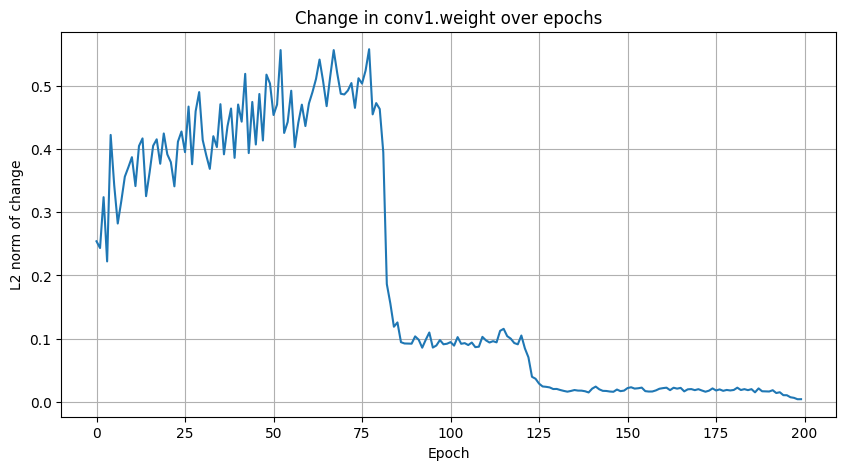

In [52]:
param_diffs_between_0_and_3 = compare_all_params_between_ranks(node0_params, node3_params, 200)
plot_param_changes_over_epochs(param_diffs_between_0_and_3, 'conv1.weight')

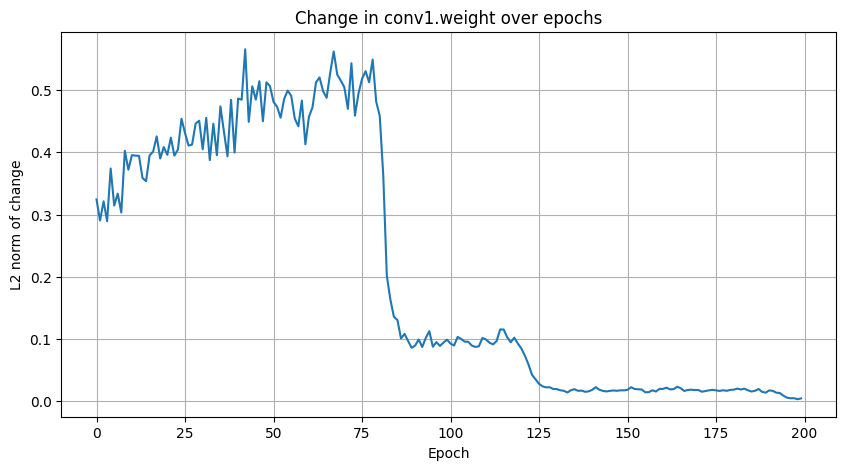

In [50]:
param_diffs_between_0_and_5 = compare_all_params_between_ranks(node0_params, node5_params, 200)
plot_param_changes_over_epochs(param_diffs_between_0_and_5, 'conv1.weight')

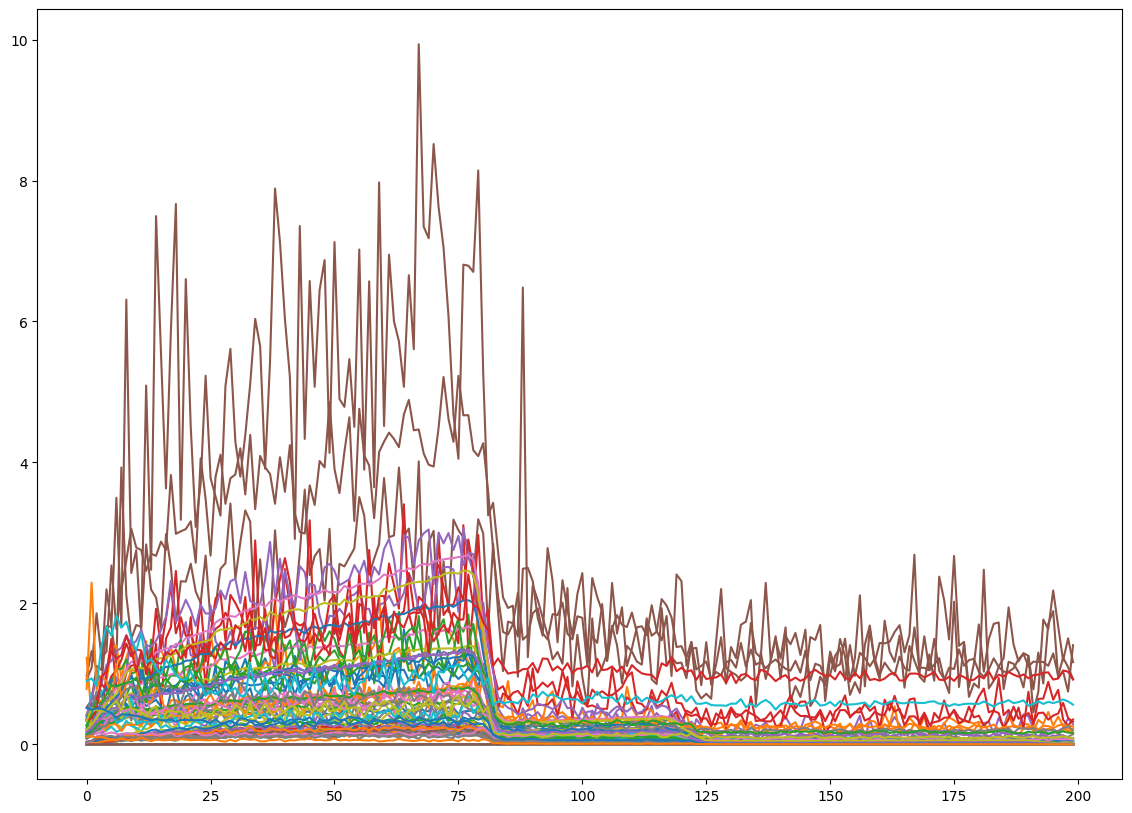

In [63]:
plot_all_param_changes_between_nodes(param_diffs_between_0_and_1)

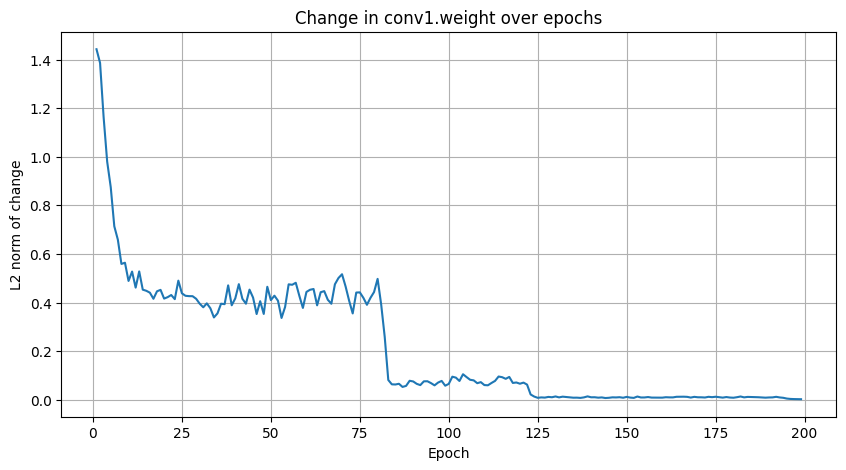

In [66]:
half_dict = 'Output/swift-iid-8W-pattern1-half-ring-2sgd-200epochs/'
half_all_params = load_all_params(half_dict, 0, num_epochs=200, map_to_cpu=True)
half_param_diffs = compare_all_params_between_epochs(half_all_params)
plot_param_changes(half_param_diffs, 'conv1.weight')

In [67]:
half_node0_params = load_all_params(half_dict, 0, num_epochs=200, map_to_cpu=True)
half_node1_params = load_all_params(half_dict, 1, num_epochs=200, map_to_cpu=True)
half_node2_params = load_all_params(half_dict, 2, num_epochs=200, map_to_cpu=True)
half_node3_params = load_all_params(half_dict, 3, num_epochs=200, map_to_cpu=True)
half_node4_params = load_all_params(half_dict, 4, num_epochs=200, map_to_cpu=True)
half_node5_params = load_all_params(half_dict, 5, num_epochs=200, map_to_cpu=True)
half_node6_params = load_all_params(half_dict, 6, num_epochs=200, map_to_cpu=True)
half_node7_params = load_all_params(half_dict, 7, num_epochs=200, map_to_cpu=True)

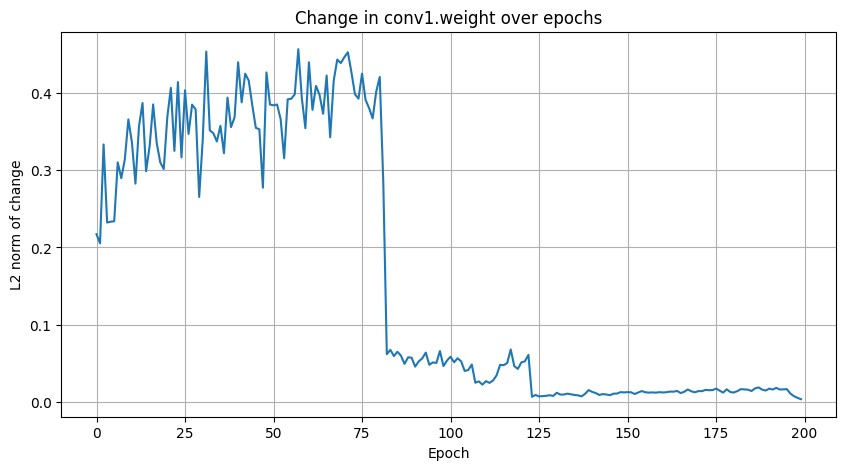

In [68]:
param_diffs_between_0_and_1 = compare_all_params_between_ranks(half_node0_params, half_node1_params, 200)
plot_param_changes_over_epochs(param_diffs_between_0_and_1, 'conv1.weight')

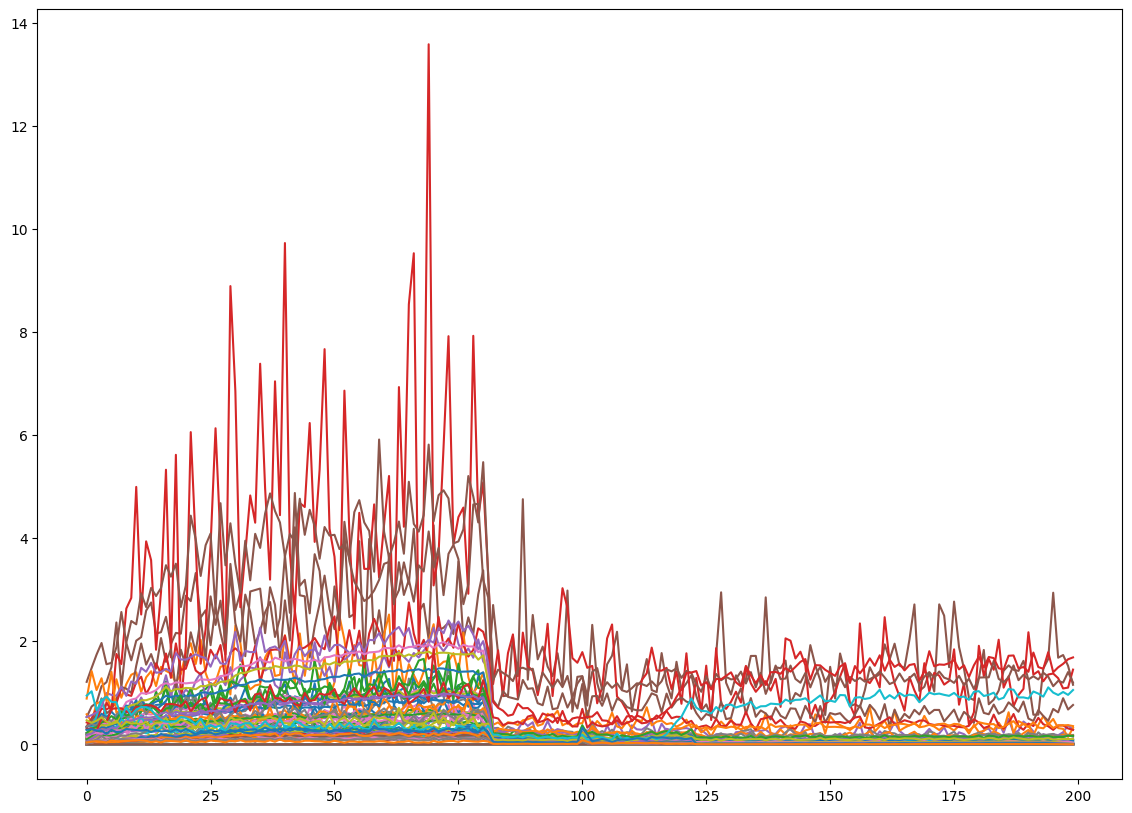

In [69]:
plot_all_param_changes_between_nodes(param_diffs_between_0_and_1)

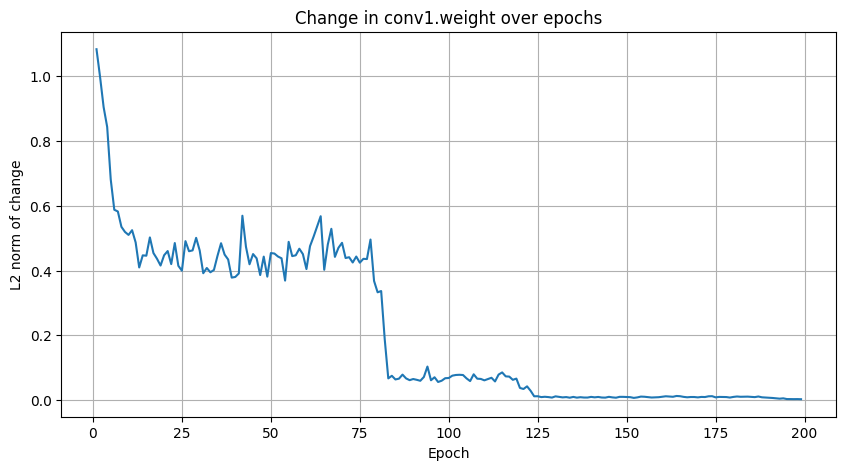

In [74]:
plot_param_changes(param_diffs, 'conv1.weight')

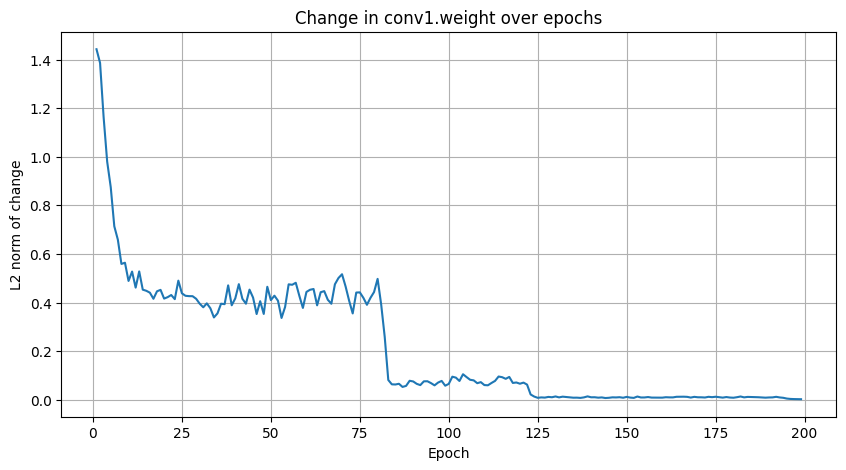

In [76]:
plot_param_changes(half_param_diffs, 'conv1.weight')

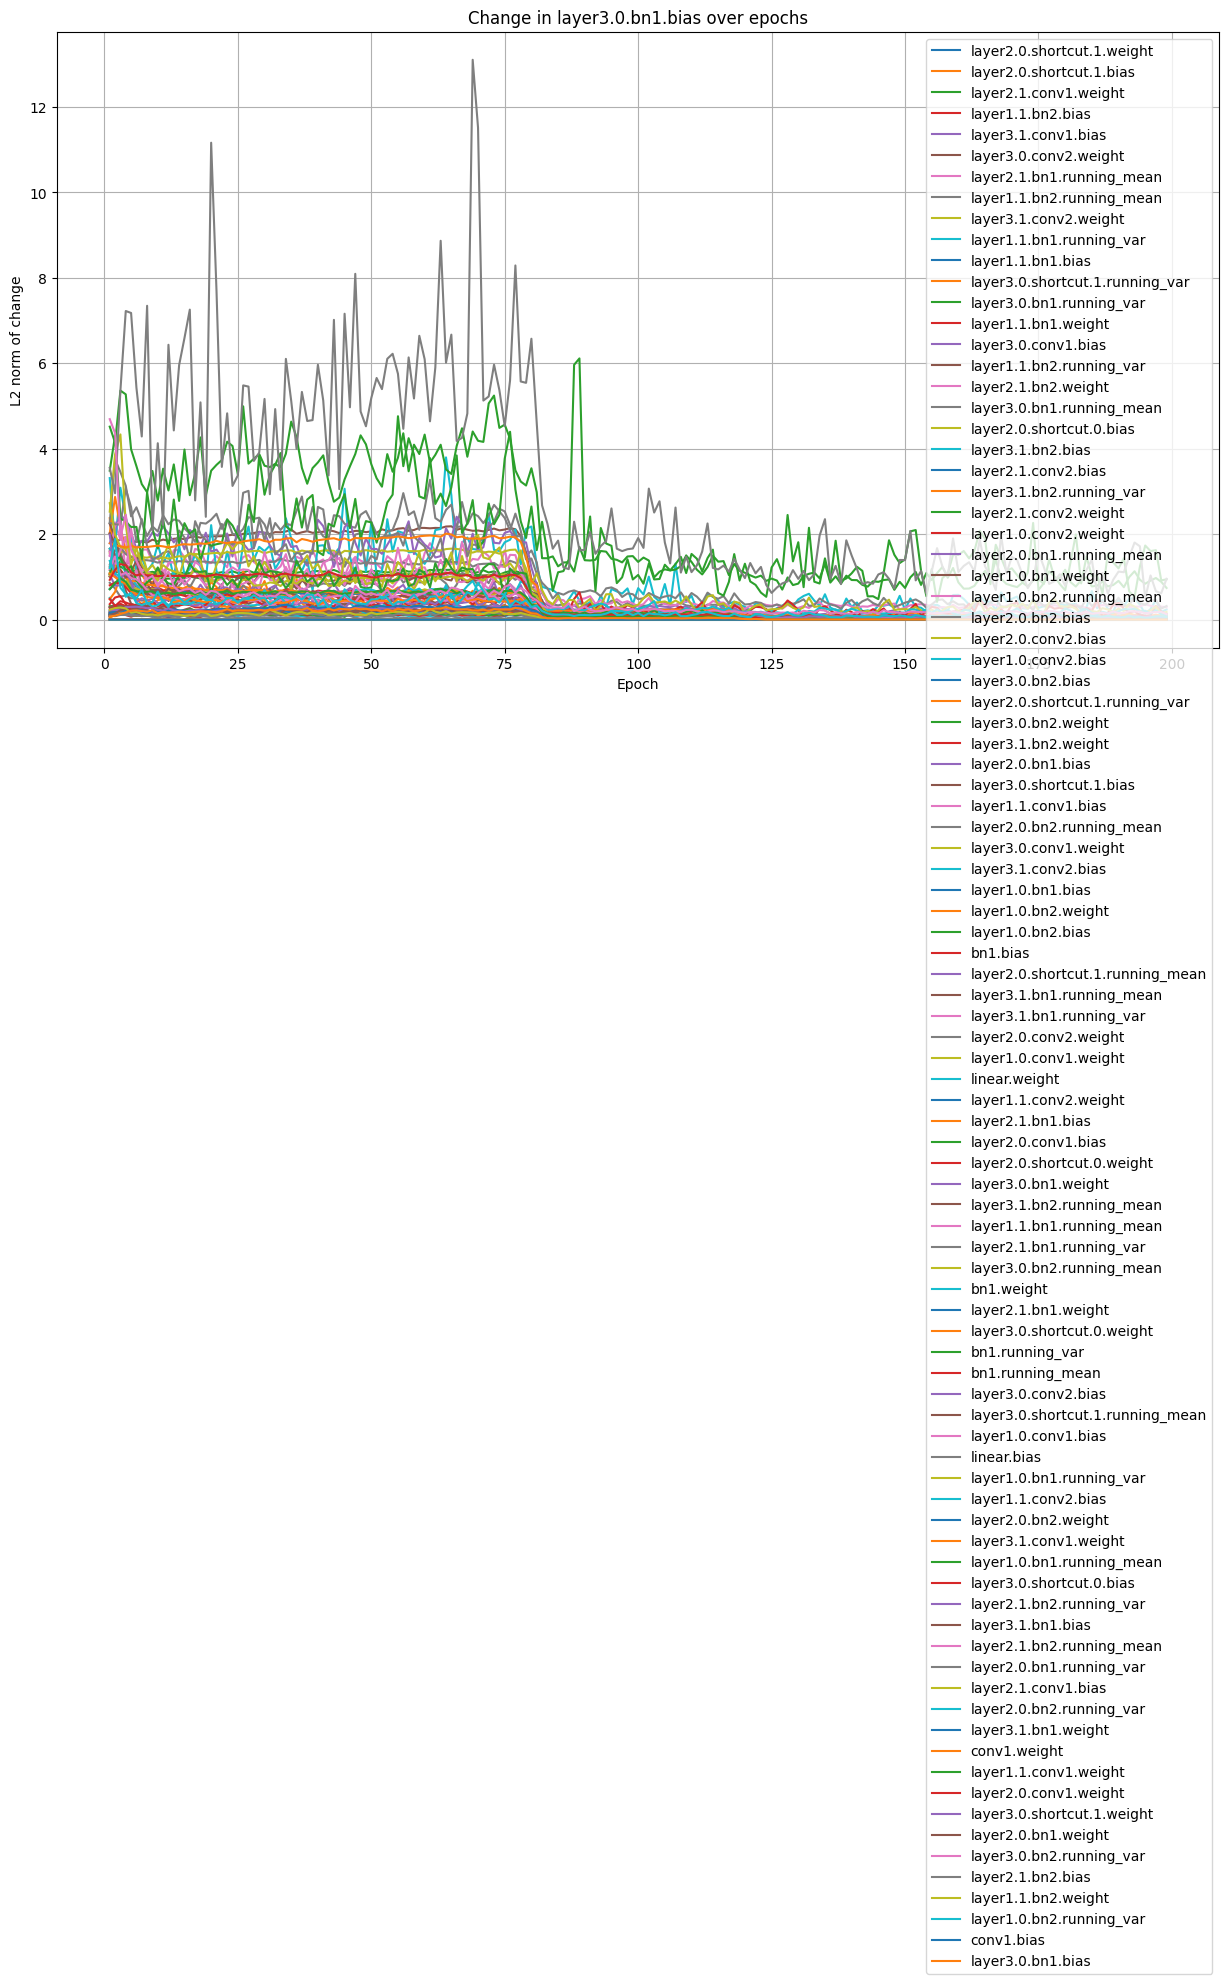

In [72]:
plot_all_param_changes(param_diffs)

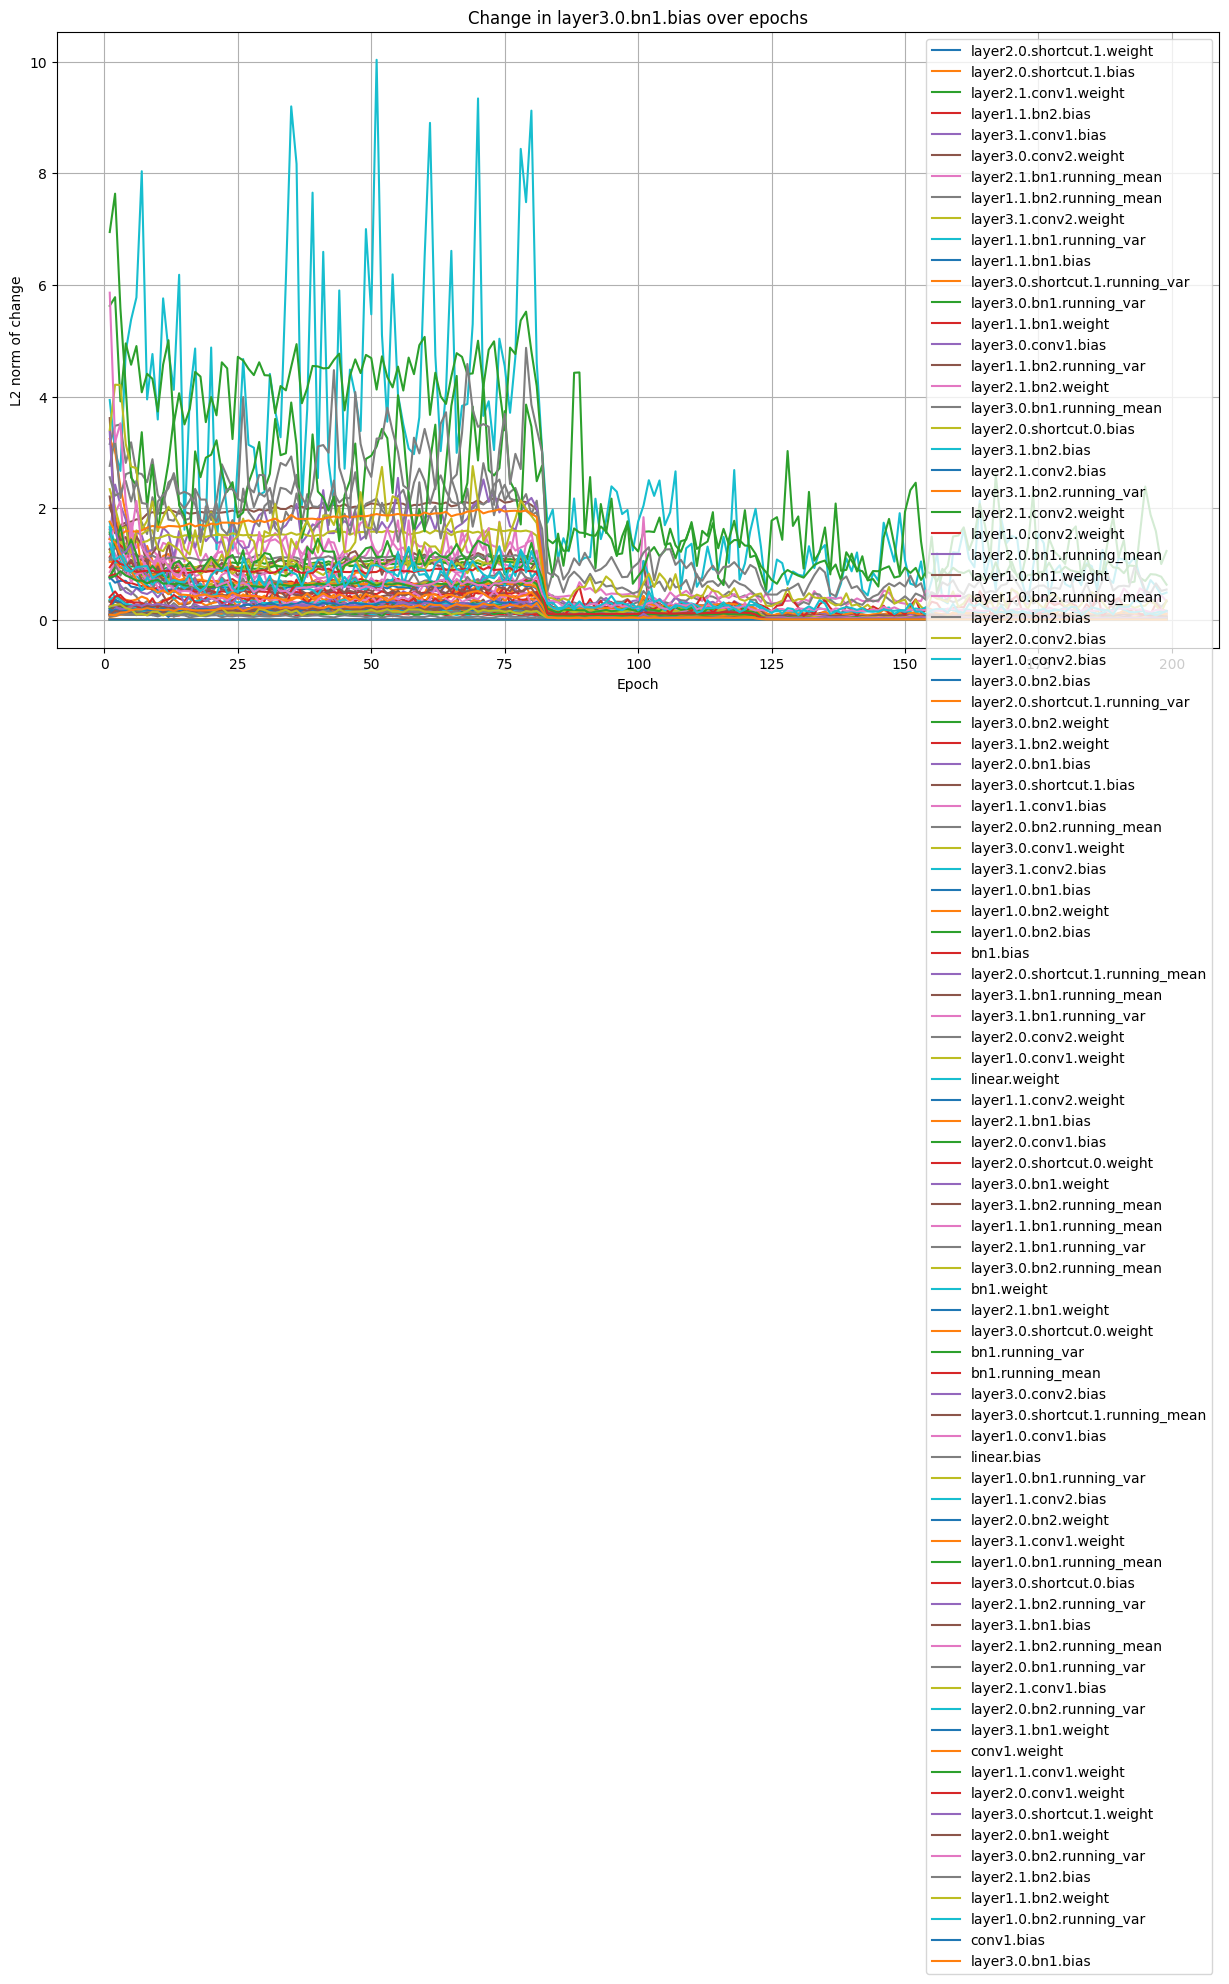

In [73]:
plot_all_param_changes(half_param_diffs)

In [82]:
def filter_diffs(param_diffs, epoch_lower=100, epoch_upper=200, change_threshold=1):
    filtered_param_name = set()
    for (epoch1, epoch2), diffs in param_diffs.items():
        if epoch1 >= epoch_lower and epoch2 <= epoch_upper:
            for param_name, change in diffs.items():
                if change > change_threshold:
                    filtered_param_name.add(param_name)
    return filtered_param_name

In [89]:
filter_diffs(param_diffs, change_threshold=0.2)

{'bn1.running_mean',
 'bn1.running_var',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn2.running_mean',
 'layer2.0.bn2.running_var',
 'layer2.1.bn1.running_mean',
 'layer2.1.bn1.running_var',
 'layer3.0.bn1.running_mean',
 'layer3.0.bn1.running_var',
 'layer3.0.bn2.running_var',
 'layer3.0.conv2.weight',
 'layer3.1.bn1.running_mean',
 'layer3.1.bn1.running_var',
 'layer3.1.conv1.weight'}

In [91]:
filter_diffs(half_param_diffs, change_threshold=0.2)

{'bn1.running_mean',
 'bn1.running_var',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn2.running_var',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn2.running_var',
 'layer2.0.shortcut.1.running_var',
 'layer2.1.bn1.running_mean',
 'layer2.1.bn1.running_var',
 'layer3.0.bn1.running_mean',
 'layer3.0.bn1.running_var',
 'layer3.0.bn2.running_mean',
 'layer3.0.bn2.running_var',
 'layer3.0.conv1.weight',
 'layer3.0.conv2.weight',
 'layer3.0.shortcut.1.running_var',
 'layer3.1.bn1.running_mean',
 'layer3.1.bn1.running_var',
 'layer3.1.bn1.weight',
 'layer3.1.bn2.running_mean',
 'layer3.1.bn2.running_var',
 'layer3.1.bn2.weight',
 'layer3.1.conv1.weight',
 'layer3.1.conv2.weight',
 'linear.bias',
 'linear.weight'}